In [1]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 372.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 3.4 MB/s eta 0:00:00


In [2]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=016c9e232024a8d17592ae8c79a5f57e9bfc9f9f9e203ce75c659becb0c9b54f
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [3]:
pip install backtrader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 5.4 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Input, Flatten, BatchNormalization, concatenate
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin
from ta.volatility import BollingerBands, AverageTrueRange
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import SMAIndicator, MACD, ADXIndicator
import matplotlib.pyplot as plt
import backtrader as bt
import streamlit as st
import random

In [5]:
def seed_everything_tf(seed: int = 42) -> None:
    #os.environ['PYTHONHASHSEED'] = str(seed)
    #torch.manual_seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    print(f"Using {seed} seed")
seed_everything_tf(42)

Using 42 seed


In [6]:
# Загрузка данных из файла
def load_data_from_file(file_path):
  try:
    data = pd.read_csv(file_path)
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    return data
  except FileNotFoundError:
      print(f"Файл '{file_path}' не найден.")
      return None

# Загрузка данных из yaho finance
def load_data_from_yf(ticker, timeframe='1d'):
  df = yf.download(ticker, interval=timeframe)
  df = df.reset_index()
  if isinstance(df.columns, pd.MultiIndex):
      df.columns = df.columns.droplevel(level=1)
  df['Date'] = pd.to_datetime(df['Date'])
  df.set_index('Date', inplace=True)
  return df

In [7]:
# Индикатор RSI
def rsi(close_prices, n=14):
  delta = close_prices.diff().dropna()
  up = delta.clip(lower=0)
  down = -delta.clip(upper=0)
  rs = up.ewm(span=n, adjust=False).mean() / down.ewm(span=n, adjust=False).mean()
  return 100 - (100 / (1 + rs))

In [17]:
# Колонки для нормализации
columns_to_scale = ['Open', 'High', 'Low', 'Close', 'Volume', 'Mean', 'Value']
# Колонки, которые не нужно нормализовать
columns_not_to_scale = ['SMA', 'RSI', 'MACD', 'Signal_Line', 'ATR', 'BB_high', 'BB_low', 'SO']

# Предобработка данных
def preprocess_data(data, window_size=30):
  # Добавление новых признаков
  data['Mean'] = (data['Open'] + data['High'] + data['Low'] + data['Close']) / 4  # Средняя цена
  data['Value'] = data['Volume'] * data['Mean']  # Объём в деньгах

  sma_indicator = SMAIndicator(close=data['Close'], window=window_size)
  data['SMA'] = sma_indicator.sma_indicator()  # Скользящая средняя

  macd_indicator = MACD(close=data['Close'])
  data['MACD'] = macd_indicator.macd()
  data['Signal_Line'] = macd_indicator.macd_signal()

  atr_indicator = AverageTrueRange(high=data['High'], low=data['Low'], close=data['Close'], window=window_size)
  data['ATR'] = atr_indicator.average_true_range()

  rsi_indicator = RSIIndicator(close=data['Close'], window=window_size)
  data['RSI'] = rsi_indicator.rsi()

  bb_indicator = BollingerBands(close=data['Close'], window=20, window_dev=2)
  data['BB_high'] = bb_indicator.bollinger_hband()
  data['BB_low'] = bb_indicator.bollinger_lband()

  so_indicator = StochasticOscillator(high=data['High'], low=data['Low'], close=data['Close'], window=14, smooth_window=3)
  data['SO'] = so_indicator.stoch()

  # Формирование признака предсказания для стратегии, основанной на использовании GAP,
  # как отношения цены открытия завтра к цене закрытия сегодня
  data["Predict"] = data['Open'].shift(-1) / data["Close"]
  #data["Predict"] = data['Close'].shift(-1) / data["Close"]

  # Удаляем строки с NaN-значениями
  data.dropna(inplace=True)

  # Сохраняем реальные цены закрытия
  Close_prices = data['Close'].values

  # Сохраняем колонку 'Predict' для целевой переменной
  y_data = data['Predict'].values

  # Удаление колонки 'Predict' и преобразование DataFrame в массив NumPy для удобства работы
  X_data = data.drop(columns=['Predict']).values

  # Проверка наличия всех колонок в данных
  missing_columns = [col for col in columns_to_scale + columns_not_to_scale if col not in data.columns]
  if missing_columns:
      raise ValueError(f"В данных отсутствуют следующие колонки: {missing_columns}")

  # Индексы колонок для масштабирования и не для масштабирования
  columns_to_scale_indices = [data.columns.get_loc(col) for col in columns_to_scale]
  columns_not_to_scale_indices = [data.columns.get_loc(col) for col in columns_not_to_scale]

  # Нормализация данных только к выбранным колонкам
  scaler = MinMaxScaler(feature_range=(0, 1))  # Можно использовать другой скейлер

  # Создание временных окон
  X, y = [], []
  for i in range(window_size, len(data)):
    # Выбираем окно данных
    window = X_data[i - window_size:i, :]

    # Разделяем данные на те, которые нужно масштабировать, и те, которые не нужно
    window_to_scale = window[:, columns_to_scale_indices]
    window_not_to_scale = window[:, columns_not_to_scale_indices]

    # Масштабируем только нужные колонки
    scaled_window_to_scale = scaler.fit_transform(window_to_scale)

    # Объединяем масштабированные и немасштабированные данные
    scaled_window = np.hstack((scaled_window_to_scale, window_not_to_scale))

    # Добавляем масштабированное окно в X
    X.append(scaled_window)

    # Добавляем целевую переменную
    y.append(y_data[i])
  # В массив array
  X, y = np.array(X), np.array(y)

  # Разделение на обучающую и тестовую выборки
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

  # Разделение Close_prices в том же отношении, что и X, y
  # Используем индексы, полученные при разбиении X и y
  split_index = len(X_train)
  Close_train = Close_prices[window_size:split_index + window_size]
  Close_test = Close_prices[split_index + window_size:]

  return X_train, X_test, y_train, y_test, Close_train, Close_test

In [9]:
class GradientBoostingWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

In [10]:
class LinearRegressionWrapper(BaseEstimator, RegressorMixin):
    def __init__(self):
        self.model = LinearRegression()

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

In [11]:
def create_ensemble_model(input_shape):
    input_layer = Input(shape=input_shape)

    # LSTM ветвь
    lstm_branch = LSTM(50, return_sequences=True)(input_layer)
    lstm_branch = Dropout(0.2)(lstm_branch)
    lstm_branch = LSTM(50, return_sequences=False)(lstm_branch)
    lstm_branch = Dropout(0.2)(lstm_branch)

    # GRU ветвь
    gru_branch = GRU(50, return_sequences=True)(input_layer)
    gru_branch = Dropout(0.2)(gru_branch)
    gru_branch = GRU(50, return_sequences=False)(gru_branch)
    gru_branch = Dropout(0.2)(gru_branch)

    # Объединение ветвей
    merged = concatenate([lstm_branch, gru_branch])

    # Полносвязные слои
    dense_layer = Dense(25, activation='relu')(merged)
    output_layer = Dense(1)(dense_layer)

    # Нейронная сеть
    nn_model = Model(inputs=input_layer, outputs=output_layer, name='nn_model')
    nn_model.compile(optimizer='adam', loss='mean_squared_error')

    # Градиентный бустинг
    gb_model = GradientBoostingWrapper(n_estimators=100, learning_rate=0.1, max_depth=3)

    # Линейная регрессия
    lr_model = LinearRegressionWrapper()

    return nn_model, gb_model, lr_model

In [12]:
def train_ensemble(nn_model, gb_model, lr_model, X_train, y_train, epochs=10, batch_size=32):
    # Обучение нейронной сети
    nn_history = nn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, verbose=1)

    # Подготовка данных для градиентного бустинга и линейной регрессии
    X_train_flat = X_train.reshape(X_train.shape[0], -1)

    # Обучение градиентного бустинга
    gb_model.fit(X_train_flat, y_train)

    # Обучение линейной регрессии
    lr_model.fit(X_train_flat, y_train)

    return nn_history, gb_model, lr_model

In [13]:
def predict_ensemble(nn_model, gb_model, lr_model, X_test):
    # Прогнозы нейронной сети
    nn_predictions = nn_model.predict(X_test)

    # Подготовка данных для градиентного бустинга и линейной регрессии
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Прогнозы градиентного бустинга
    gb_predictions = gb_model.predict(X_test_flat)

    # Прогнозы линейной регрессии
    lr_predictions = lr_model.predict(X_test_flat)

    # Усреднение прогнозов
    ensemble_predictions = (nn_predictions.flatten() + gb_predictions + lr_predictions) / 3

    return ensemble_predictions, gb_predictions, lr_predictions

In [14]:
def calculate_metrics(predictions, y_test):
  # метрика: точность направления движения цены
  pred_sign = np.sign(predictions -1)
  test_sign = np.sign(y_test - 1)
  direction_accuracy = accuracy_score(test_sign, pred_sign)
  rmse = np.mean((predictions - y_test) ** 2) ** 0.5
  mae = np.mean(np.abs(predictions - y_test))
  average = y_test.mean()
  rmse2avg = rmse / average
  mae2avg = mae / average
  print(f"Точность направления движения цены: {direction_accuracy:.4f}")
  print(f"Средняя абсолютная ошибка цены (MAE): {mae:.4f}")
  print(f"Средняя квадратичная ошибка цены (RMSE): {rmse:.4f}")
  print(f"Относительная средняя абсолютная ошибка цены (MAE): {mae2avg:.4f}")
  print(f"Относительная средняя квадратичная ошибка цены (RMSE): {rmse2avg:.4f}")
  return direction_accuracy, rmse, mae, rmse2avg, mae2avg

In [15]:
# Загрузка данных
#file_path = 'stock_data.csv'  # Замените на путь к вашему файлу
#data = load_data_from_file(file_path)
data = load_data_from_yf("AAPL")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [18]:
# Предобработка данных
X_train, X_test, y_train, y_test, Close_train, Close_test = preprocess_data(data)

In [19]:
# Создание ансамбля моделей
nn_model, gb_model, lr_model = create_ensemble_model((X_train.shape[1], X_train.shape[2]))

In [20]:
# Обучение ансамбля
nn_history, gb_model, lr_model = train_ensemble(nn_model, gb_model, lr_model, X_train, y_train, epochs=10)

Epoch 1/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 28s 75ms/step - loss: 0.0717 - val_loss: 0.0024
Epoch 2/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - loss: 0.0052 - val_loss: 0.0015
Epoch 3/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - loss: 0.0035 - val_loss: 0.0010
Epoch 4/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - loss: 0.0027 - val_loss: 2.9314e-04
Epoch 5/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - loss: 0.0023 - val_loss: 3.2219e-04
Epoch 6/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - loss: 0.0019 - val_loss: 2.2310e-04
Epoch 7/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - loss: 0.0017 - val_loss: 2.0143e-04
Epoch 8/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - loss: 0.0015 - val_loss: 2.3532e-04
Epoch 9/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - loss: 0.0012 - val_loss: 2.2741e-04
Epoch 10/10
249/249 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - loss: 0.0011 - val_loss: 1.5831e-04


In [21]:
# Тестирование модели - прогнозирование с использованием ансамбля, градиентного бустинга и линейной регрессии
ensemble_predictions, gb_predictions, lr_predictions = predict_ensemble(nn_model, gb_model, lr_model, X_test)

# Расчет метрик для ансамбля
print(f"------------Метрики для ансамбля моделей--------------")
ensemble_direction_accuracy, ensemble_rmse, ensemble_mae, ensemble_rmse2avg, ensemble_mae2avg  = calculate_metrics(ensemble_predictions, y_test)
# Расчет метрик для градиентного бустинга
print(f"------------Метрики для градиентного бустинга---------")
gb_direction_accuracy, gb_rmse, gb_mae, gb_rmse2avg, gb_mae2avg  = calculate_metrics(gb_predictions, y_test)
# Расчет метрик для линейной регрессии
print(f"------------Метрики для линейной регрессии------------")
lr_direction_accuracy, lr_rmse, lr_mae, lr_rmse2avg, lr_mae2avg  = calculate_metrics(lr_predictions, y_test)

70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
------------Метрики для ансамбля моделей--------------
Точность направления движения цены: 0.4670
Средняя абсолютная ошибка цены (MAE): 0.0565
Средняя квадратичная ошибка цены (RMSE): 0.0705
Относительная средняя абсолютная ошибка цены (MAE): 0.0565
Относительная средняя квадратичная ошибка цены (RMSE): 0.0705
------------Метрики для градиентного бустинга---------
Точность направления движения цены: 0.4634
Средняя абсолютная ошибка цены (MAE): 0.0395
Средняя квадратичная ошибка цены (RMSE): 0.0433
Относительная средняя абсолютная ошибка цены (MAE): 0.0395
Относительная средняя квадратичная ошибка цены (RMSE): 0.0433
------------Метрики для линейной регрессии------------
Точность направления движения цены: 0.5158
Средняя абсолютная ошибка цены (MAE): 0.0209
Средняя квадратичная ошибка цены (RMSE): 0.0301
Относительная средняя абсолютная ошибка цены (MAE): 0.0209
Относительная средняя квадратичная ошибка цены (RMSE): 0.0301


In [22]:
count_less_than_1 = np.sum(ensemble_predictions < 1)
count_great_than_1 = np.sum(ensemble_predictions > 1)
print(f"Количество элементов меньше 1: {count_less_than_1}")
print(f"Количество элементов больше 1: {count_great_than_1}")

Количество элементов меньше 1: 2037
Количество элементов больше 1: 175


In [23]:
# Сохранение метрик в файл
metrics = {
    'Модель': "ensemble_model",
    'Точность направления': ensemble_direction_accuracy,
    'Средняя абсолютная ошибка': ensemble_mae,
    'Средняя квадратичная ошибка': ensemble_rmse,
    'Относительная средняя абсолютная ошибка': ensemble_mae2avg,
    'Относительная средняя квадратичная ошибка': ensemble_rmse2avg
}
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv('metrics.csv', index=False)

In [24]:
# Создание дашборда с использованием Streamlit
def create_dashboard(data, predictions, y_test):
    st.title('Дашборд торговой стратегии')
    st.write("### График прогнозов и реальных цен")
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Реальные цены')
    plt.plot(predictions, label='Прогнозы')
    plt.legend()
    st.pyplot(plt)

    st.write("### Метрики модели")
    metrics_df = pd.read_csv('metrics.csv')
    st.table(metrics_df)

2025-03-20 14:37:42.769 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 14:37:42.927 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-03-20 14:37:42.928 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 14:37:42.929 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 14:37:42.930 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 14:37:42.931 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 14:37:42.932 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 14:37:42.960 Thread 'MainThread': mi

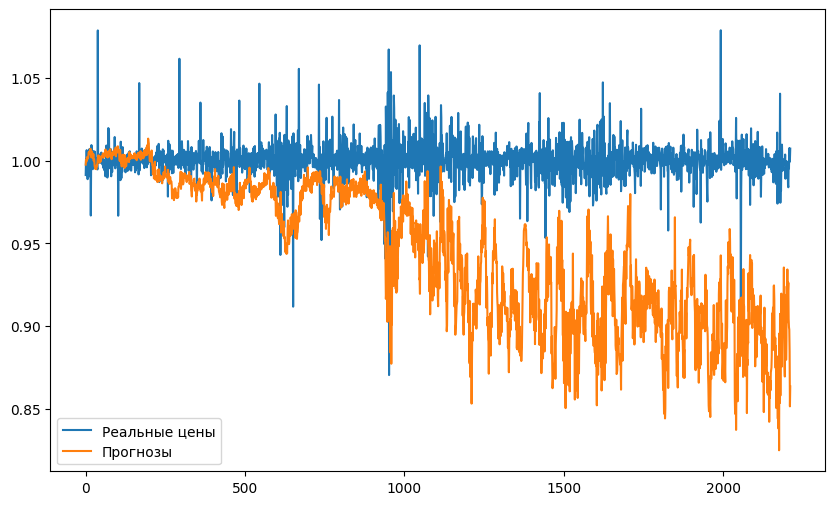

In [25]:
create_dashboard(data, ensemble_predictions, y_test)

In [26]:
# Создание стратегии для backtrader на основе Ensemble
class SimulationStrategyEnsemble(bt.Strategy):
    def __init__(self):
        self.prediction_index = 0  # Индекс для отслеживания текущего предсказания

    def next(self):
        if self.prediction_index < len(ensemble_predictions):
            prediction = ensemble_predictions[self.prediction_index]
            if prediction > 1:  # Если предсказание роста цены
                if not self.position:
                    self.buy()  # Открываем длинную позицию
            elif prediction < 1:  # Если предсказание падения цены
                if self.position:
                    self.sell()  # Закрываем позицию
            self.prediction_index += 1

In [27]:
# Создание стратегии для backtrader на основе GradientBoosting
class SimulationStrategyGB(bt.Strategy):
    def __init__(self):
        self.prediction_index = 0  # Индекс для отслеживания текущего предсказания

    def next(self):
        if self.prediction_index < len(gb_predictions):
            prediction = gb_predictions[self.prediction_index]
            if prediction > 1:  # Если предсказание роста цены
                if not self.position:
                    self.buy()  # Открываем длинную позицию
            elif prediction < 1:  # Если предсказание падения цены
                if self.position:
                    self.sell()  # Закрываем позицию
            self.prediction_index += 1

In [28]:
# Создание стратегии для backtrader на основе LinearRegression
class SimulationStrategyLR(bt.Strategy):
    def __init__(self):
        self.prediction_index = 0  # Индекс для отслеживания текущего предсказания

    def next(self):
        if self.prediction_index < len(lr_predictions):
            prediction = lr_predictions[self.prediction_index]
            if prediction > 1:  # Если предсказание роста цены
                if not self.position:
                    self.buy()  # Открываем длинную позицию
            elif prediction < 1:  # Если предсказание падения цены
                if self.position:
                    self.sell()  # Закрываем позицию
            self.prediction_index += 1

In [29]:
# Тестирование ансамбля моделей
# Создание экземпляра Cerebro
cerebro = bt.Cerebro()

# Добавление стратегии
cerebro.addstrategy(SimulationStrategyEnsemble)

# Подготовка тестовых данных для backtrader
test_data = data.iloc[-len(X_test):]  # Выбираем тестовую часть данных
test_data = bt.feeds.PandasData(dataname=test_data)

# Добавление данных
cerebro.adddata(test_data)

# Добавление анализаторов
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name="ta")
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name="sharpe")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='timereturn')

# Установка начального капитала
cerebro.broker.set_cash(10000.0)

# Запуск симуляции с анализаторами
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
analysis = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
Final Portfolio Value: 10009.63


In [30]:
# Вывод дополнительных характеристик
def print_trade_analysis(analyzer):
    print("\n--- Trade Analysis ---")
    print(f"Total Trades: {analyzer.total.total}")
    print(f"Total Closed Trades: {analyzer.total.closed}")
    print(f"Total Open Trades: {analyzer.total.open}")
    print(f"Total Won: {analyzer.won.total}")
    print(f"Total Lost: {analyzer.lost.total}")
    print(f"Win Rate: {analyzer.won.total / analyzer.total.closed * 100:.2f}%")
    print(f"Average Win: {analyzer.won.pnl.average:.2f}")
    print(f"Average Loss: {analyzer.lost.pnl.average:.2f}")
    #print(f"Profit Factor: {analyzer.pnl.net.profit_factor:.2f}")

def print_sharpe_ratio(analyzer):
    print("\n--- Sharpe Ratio ---")
    print(f"Sharpe Ratio: {analyzer.get('sharperatio', 'N/A'):.2f}")

def print_drawdown(analyzer):
    print("\n--- Drawdown ---")
    print(f"Max Drawdown: {analyzer.max.drawdown:.2f}%")
    print(f"Max Money Drawdown: {analyzer.max.moneydown:.2f}")

# Вывод результатов анализа
print_trade_analysis(analysis[0].analyzers.ta.get_analysis())
print_sharpe_ratio(analysis[0].analyzers.sharpe.get_analysis())
print_drawdown(analysis[0].analyzers.drawdown.get_analysis())
capital_history = analysis[0].analyzers.timereturn.get_analysis().items()

# Визуализация результатов
cerebro.plot()


--- Trade Analysis ---
Total Trades: 17
Total Closed Trades: 17
Total Open Trades: 0
Total Won: 13
Total Lost: 4
Win Rate: 76.47%
Average Win: 0.85
Average Loss: -0.35

--- Sharpe Ratio ---
Sharpe Ratio: -47.93

--- Drawdown ---
Max Drawdown: 0.02%
Max Money Drawdown: 2.07


<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 4 Axes>]]

In [31]:
# Тестирование градиентного бустинга
# Создание экземпляра Cerebro
cerebro = bt.Cerebro()

# Добавление стратегии для GB
cerebro.addstrategy(SimulationStrategyGB)

# Подготовка тестовых данных для backtrader
test_data = data.iloc[-len(X_test):]  # Выбираем тестовую часть данных
test_data = bt.feeds.PandasData(dataname=test_data)

# Добавление данных
cerebro.adddata(test_data)

# Установка начального капитала
cerebro.broker.set_cash(10000.0)

# Запуск симуляции с анализаторами
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
analysis = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
Final Portfolio Value: 10009.65


In [32]:
# Тестирование линейной регрессии
# Создание экземпляра Cerebro
cerebro = bt.Cerebro()

# Добавление стратегии для LR
cerebro.addstrategy(SimulationStrategyLR)

# Подготовка тестовых данных для backtrader
test_data = data.iloc[-len(X_test):]  # Выбираем тестовую часть данных
test_data = bt.feeds.PandasData(dataname=test_data)

# Добавление данных
cerebro.adddata(test_data)

# Установка начального капитала
cerebro.broker.set_cash(10000.0)

# Запуск симуляции с анализаторами
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
analysis = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 10000.00
Final Portfolio Value: 10080.41


In [33]:
# Добавление графика капитала в дашборд
def create_dashboard2(data, predictions, y_test, capital_history):
    st.title('Дашборд торговой стратегии')
    st.write("### График прогнозов и реальных цен")
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(y_test, label='Реальные цены')
    ax.plot(predictions, label='Прогнозы')
    ax.legend()
    st.pyplot(fig)

    st.write("### График изменения капитала")
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(capital_history, label='Капитал')
    ax.set_xlabel('Время')
    ax.set_ylabel('Капитал')
    ax.legend()
    st.pyplot(fig)

    st.write("### Метрики модели")
    metrics_df = pd.read_csv('metrics.csv')
    st.table(metrics_df)

In [34]:
create_dashboard2(data, ensemble_predictions, y_test, capital_history)

2025-03-20 14:38:41.943 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 14:38:41.944 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 14:38:41.945 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 14:38:41.946 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 14:38:41.947 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 14:38:41.948 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 14:38:41.968 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-20 14:38:42.413 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

ВЫВОДЫ:
1. Торговая стратегия на основе ансамбля генерирует небольшую прибыль
2. Линейная модель формирует лучший результат по сравнению с градиентным бустингом и ансамблем из них и нейронной сети на основе LSTM и GRU
